In [48]:
from random import random, seed, randrange
from math import floor, pi
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time
import pandas as pd
from scipy.integrate import simps, trapz, cumtrapz
from scipy.ndimage.filters import gaussian_filter1d
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 9]

In [82]:
data_02 = pd.read_csv('ex1_02.csv')
data_02 = data_02[data_02.Pf > 70]
data_05 = pd.read_csv('ex1_05.csv')
data_05 = data_05[data_05.Pf < 300 ]
data_08 = pd.read_csv('ex1_08.csv')
df = data_02.append( data_05 ).append( data_08 )
df['yc0'] = df['yc0'].astype('str')

In [83]:
data_02.describe()

,yc0,P0,N_equil,N_prod,s_box,ycf,Pf,rhoco,rhome,ycf_s,Pf_s,rhoco_s,rhome_s,t_comp
count,7.900000e+01,79.0,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000
mean,2.000000e-01,100.0,3012.658228,3012.658228,37.341772,0.201903,96.445705,0.000522,0.002063,0.020931,9.064499,0.000066,0.000132,1569.896638
std,8.379879e-17,0.0,1006.309211,1006.309211,12.578865,0.001605,0.565479,0.000005,0.000011,0.000929,0.242256,0.000003,0.000005,217.834869
min,2.000000e-01,100.0,2000.000000,2000.000000,25.000000,0.198374,95.254373,0.000512,0.002035,0.018938,8.403893,0.000060,0.000117,1482.455639
25%,2.000000e-01,100.0,2000.000000,2000.000000,25.000000,0.200836,96.089385,0.000519,0.002057,0.020277,8.868794,0.000064,0.000127,1491.676218
50%,2.000000e-01,100.0,4000.000000,4000.000000,25.000000,0.201808,96.430825,0.000521,0.002063,0.020822,9.078602,0.000066,0.000131,1503.575478
75%,2.000000e-01,100.0,4000.000000,4000.000000,50.000000,0.202988,96.801124,0.000526,0.002069,0.021566,9.226521,0.000068,0.000137,1522.302671
max,2.000000e-01,100.0,4000.000000,4000.000000,50.000000,0.206349,97.950597,0.000533,0.002094,0.024370,9.609464,0.000076,0.000143,2740.989030


In [84]:
df_means = df.groupby(['yc0',"N_equil", "N_prod", "s_box"]).agg({'ycf_s': ['mean'], 'Pf_s': ['mean'],'rhoco_s':'mean',  'rhome_s':'mean', 't_comp':'mean'}).stack().reset_index().drop(['level_4'],axis=1).rename( columns = {'ycf_s':"ycf_run",'Pf_s':"Pf_run",'rhoco_s':"rhoco_run",'rhome_s':"rhome_run"})
df_devs = df.groupby(['yc0',"N_equil", "N_prod", "s_box"]).agg({'ycf':['std'],'Pf':['std'],'rhoco':['std'], 'rhome':['std'], }).stack().reset_index().drop(['level_4'],axis=1).rename( columns = {'ycf':"ycf_result",'Pf':"Pf_result",'rhoco':"rhoco_result",'rhome':"rhome_result"})
df_merged = df_means.merge( df_devs )
df_full = df_merged.assign(ycf_s = np.sqrt( df_merged.ycf_run**2 + df_merged.ycf_result**2 )).assign(Pf_s = np.sqrt( df_merged.Pf_run**2 + df_merged.Pf_result**2 )).assign(rhoco_s = np.sqrt( df_merged.rhoco_run**2 + df_merged.rhoco_result**2 )).assign(rhome_s = np.sqrt( df_merged.rhome_run**2 + df_merged.rhome_result**2 ))
df_full

,yc0,N_equil,N_prod,s_box,ycf_run,Pf_run,rhoco_run,rhome_run,t_comp,ycf_result,Pf_result,rhoco_result,rhome_result,ycf_s,Pf_s,rhoco_s,rhome_s
0,0.2,2000.0,2000.0,25.0,0.021268,9.001694,0.000067,0.000131,1622.910338,0.001205,0.457810,0.000004,0.000006,0.021303,9.013328,0.000067,0.000131
1,0.2,2000.0,2000.0,50.0,0.021184,9.047361,0.000067,0.000131,1507.306778,0.001547,0.485567,0.000004,0.000007,0.021241,9.060382,0.000067,0.000132
2,0.2,2000.0,4000.0,25.0,0.020830,9.123923,0.000066,0.000133,1493.429114,0.001282,0.463262,0.000005,0.000010,0.020869,9.135677,0.000066,0.000133
3,0.2,2000.0,4000.0,50.0,0.021076,9.123875,0.000067,0.000134,1519.043638,0.002131,0.549017,0.000006,0.000016,0.021184,9.140379,0.000067,0.000135
4,0.2,4000.0,2000.0,25.0,0.020907,9.041650,0.000066,0.000134,1490.839210,0.001244,0.759067,0.000006,0.000010,0.020944,9.073457,0.000066,0.000134
5,0.2,4000.0,2000.0,50.0,0.020319,9.078330,0.000065,0.000132,1516.413898,0.001702,0.473863,0.000004,0.000010,0.020390,9.090689,0.000065,0.000132
6,0.2,4000.0,4000.0,25.0,0.021039,9.067419,0.000066,0.000132,1571.386052,0.001514,0.481677,0.000005,0.000011,0.021093,9.080203,0.000066,0.000132
7,0.2,4000.0,4000.0,50.0,0.020850,9.030023,0.000065,0.000127,1831.585091,0.001501,0.471655,0.000004,0.000012,0.020904,9.042332,0.000065,0.000128
8,0.5,2000.0,2000.0,25.0,0.025364,10.418078,0.000129,0.000110,2321.214818,0.003915,0.841512,0.000026,0.000013,0.025665,10.452009,0.000131,0.000111
9,0.5,2000.0,2000.0,50.0,0.025507,10.484887,0.000128,0.000113,3124.727782,0.002493,0.590071,0.000013,0.000006,0.025629,10.501478,0.000129,0.000113


In [85]:
df_full['complexity'] = np.add( np.add( (df_full.N_equil == 4000).astype(int), (df_full.N_prod == 4000).astype(int)  ), (df_full.s_box == 50).astype(int) )
df_full

,yc0,N_equil,N_prod,s_box,ycf_run,Pf_run,rhoco_run,rhome_run,t_comp,ycf_result,Pf_result,rhoco_result,rhome_result,ycf_s,Pf_s,rhoco_s,rhome_s,complexity
0,0.2,2000.0,2000.0,25.0,0.021268,9.001694,0.000067,0.000131,1622.910338,0.001205,0.457810,0.000004,0.000006,0.021303,9.013328,0.000067,0.000131,0
1,0.2,2000.0,2000.0,50.0,0.021184,9.047361,0.000067,0.000131,1507.306778,0.001547,0.485567,0.000004,0.000007,0.021241,9.060382,0.000067,0.000132,1
2,0.2,2000.0,4000.0,25.0,0.020830,9.123923,0.000066,0.000133,1493.429114,0.001282,0.463262,0.000005,0.000010,0.020869,9.135677,0.000066,0.000133,1
3,0.2,2000.0,4000.0,50.0,0.021076,9.123875,0.000067,0.000134,1519.043638,0.002131,0.549017,0.000006,0.000016,0.021184,9.140379,0.000067,0.000135,2
4,0.2,4000.0,2000.0,25.0,0.020907,9.041650,0.000066,0.000134,1490.839210,0.001244,0.759067,0.000006,0.000010,0.020944,9.073457,0.000066,0.000134,1
5,0.2,4000.0,2000.0,50.0,0.020319,9.078330,0.000065,0.000132,1516.413898,0.001702,0.473863,0.000004,0.000010,0.020390,9.090689,0.000065,0.000132,2
6,0.2,4000.0,4000.0,25.0,0.021039,9.067419,0.000066,0.000132,1571.386052,0.001514,0.481677,0.000005,0.000011,0.021093,9.080203,0.000066,0.000132,2
7,0.2,4000.0,4000.0,50.0,0.020850,9.030023,0.000065,0.000127,1831.585091,0.001501,0.471655,0.000004,0.000012,0.020904,9.042332,0.000065,0.000128,3
8,0.5,2000.0,2000.0,25.0,0.025364,10.418078,0.000129,0.000110,2321.214818,0.003915,0.841512,0.000026,0.000013,0.025665,10.452009,0.000131,0.000111,0
9,0.5,2000.0,2000.0,50.0,0.025507,10.484887,0.000128,0.000113,3124.727782,0.002493,0.590071,0.000013,0.000006,0.025629,10.501478,0.000129,0.000113,1


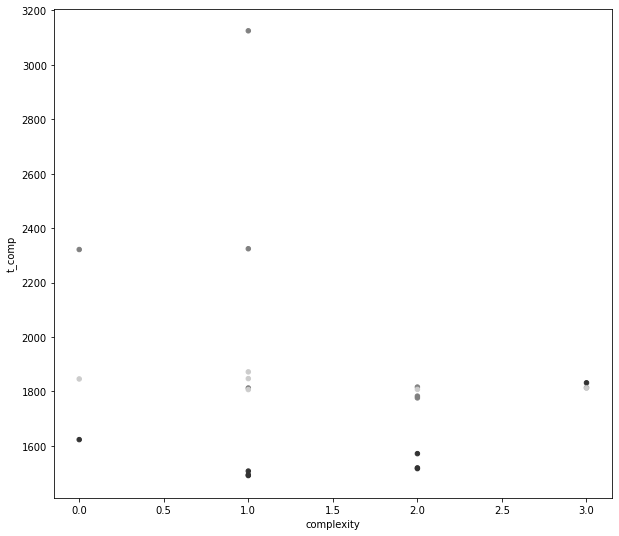

In [86]:
df_full.plot( kind = "scatter", x = 'complexity', y = 't_comp', c = 'yc0')

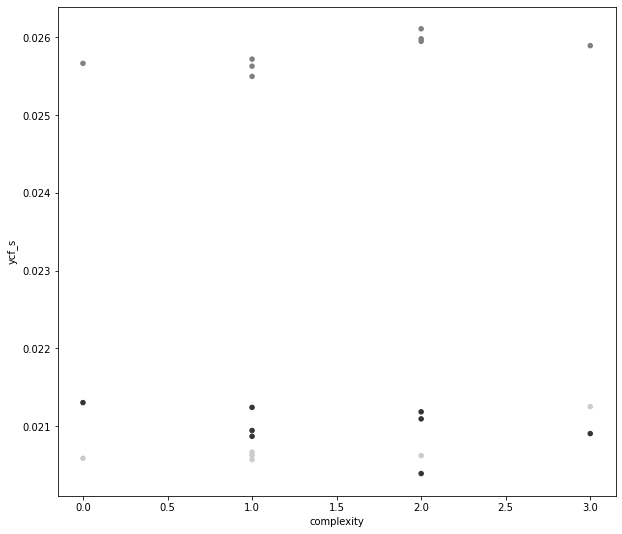

In [87]:
df_full.plot( kind = "scatter", x = 'complexity', y = 'ycf_s', c = 'yc0')

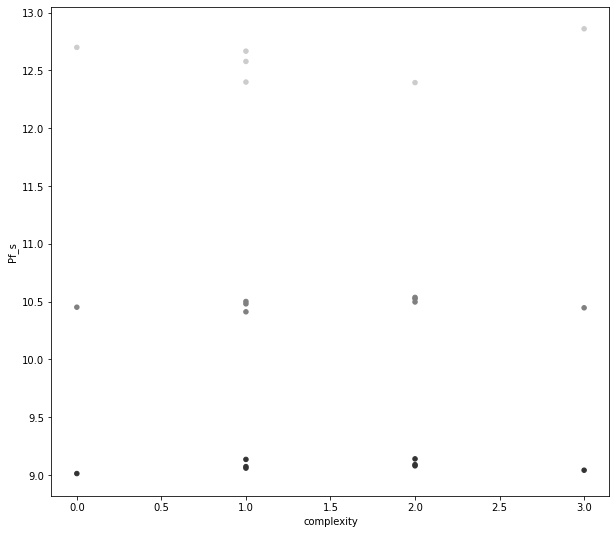

In [88]:
df_full.plot( kind = "scatter", x = 'complexity', y = 'Pf_s', c = 'yc0')

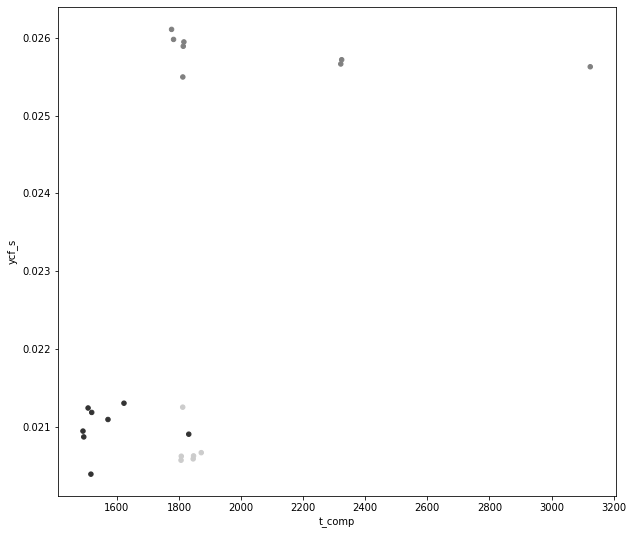

In [89]:
df_full.plot( kind = "scatter", x = 't_comp', y = 'ycf_s', c = 'yc0')

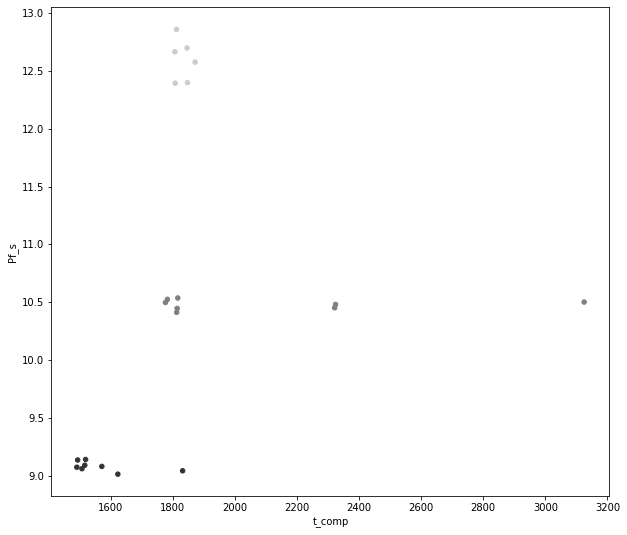

In [90]:
df_full.plot( kind = "scatter", x = 't_comp', y = 'Pf_s', c = 'yc0')

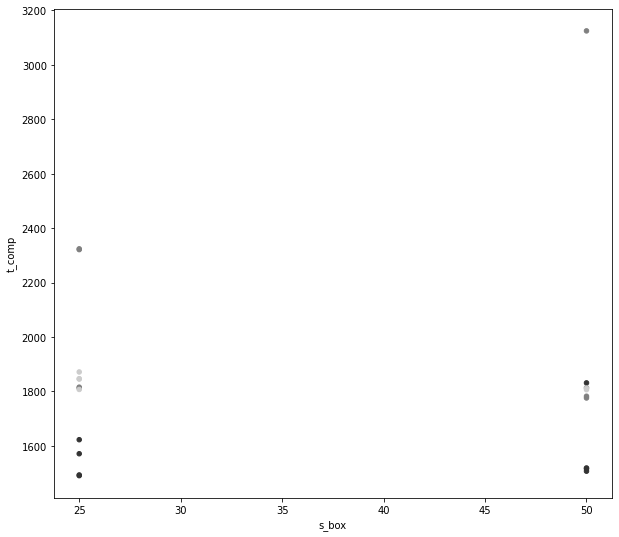

In [91]:
df_full.plot( kind = "scatter", x = 's_box', y = 't_comp', c = 'yc0')

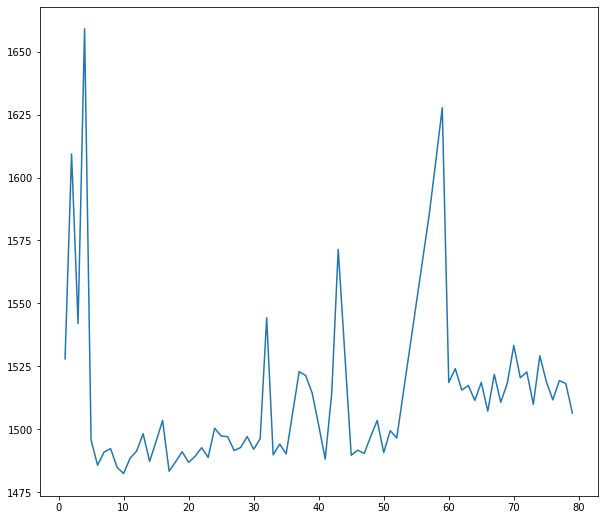

In [93]:
plt.plot( data_08[data_08.t_comp < 1800].t_comp)